#Setup

In [1]:
!pip install flatbuffers prettytable
!git clone https://github.com/eliberis/tflite-tools.git tflite_tools

Cloning into 'tflite_tools'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 320 (delta 262), reused 283 (delta 236), pack-reused 0
Receiving objects: 100% (320/320), 164.03 KiB | 2.93 MiB/s, done.
Resolving deltas: 100% (262/262), done.


In [2]:
!pip install -U tensorboard_plugin_profile tensorflow-addons
!pip install -q tensorflow-model-optimization

%load_ext tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.8 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Data Preprocessing

In [4]:
class_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

def preprocess(x):
    x = x.astype('float32') / 255
    return x

x_train = preprocess(x_train)
x_test = preprocess(x_test)

subsample_ratio = 1.0
subsample_index = int(len(x_train) * subsample_ratio)
x_train = x_train[:subsample_index]
y_train = y_train[:subsample_index]

subsample_index = int(len(x_test) * subsample_ratio)
x_test = x_test[:subsample_index]
y_test = y_test[:subsample_index]


170498071/170498071 [==============================] - 4s 0us/step


In [5]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128

train_data = train_data.shuffle(16 * batch_size)

train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

cifar10_means = np.array([np.mean(x_train[:, :, :, 0]), np.mean(x_train[:, :, :, 1]), np.mean(x_train[:, :, :, 2])])
cifar10_stds = np.array([np.std(x_train[:, :, :, 0]), np.std(x_train[:, :, :, 1]), np.std(x_train[:, :, :, 2])])

def random_shift(x, shift_amount):
    """ Randomly shifts images by up to HxW pixels = `shift_amount`. """
    h_pixels, w_pixels = shift_amount
    orig = tf.shape(x)
    paddings = tf.constant([[0, 0], [w_pixels, w_pixels], [h_pixels, h_pixels], [0, 0]])
    x = tf.pad(x, mode="SYMMETRIC", paddings=paddings)
    return tf.image.random_crop(x, size=orig)

def transform_data(xs, ys):

    xs = tf.image.random_flip_left_right(xs)
    xs = tfa.image.random_cutout(xs, mask_size=(12, 12))
    xs = random_shift(xs, (4, 4))

    return xs, ys

def normalise(xs, ys):

    xs = (xs - cifar10_means) / cifar10_stds
    return xs, ys

def undo_normalisation(x):
    return np.clip(x * cifar10_stds + cifar10_means, 0.0, 1.0)

# Augmentation and normalisation
train_data = train_data.map(transform_data).map(normalise)
test_data = test_data.map(normalise)

Train batch:
	automobile


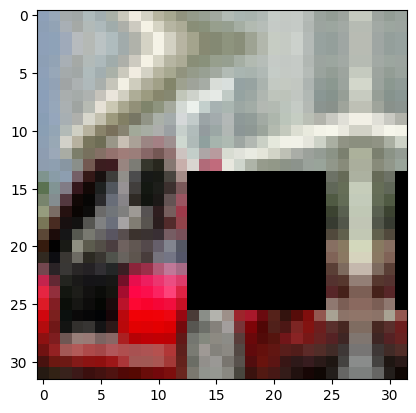

	ship


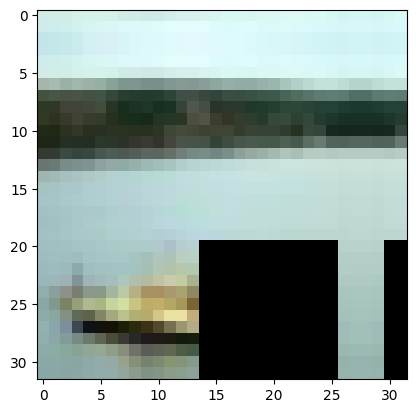

	horse


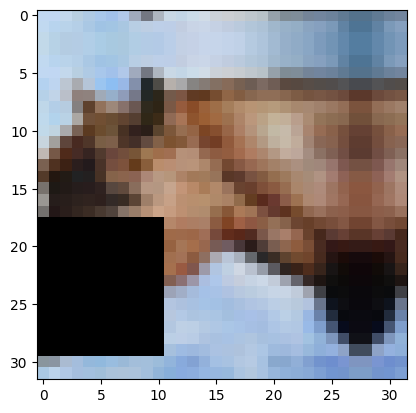

Test batch:
	cat


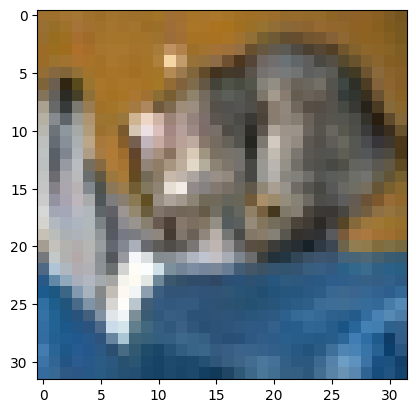

	ship


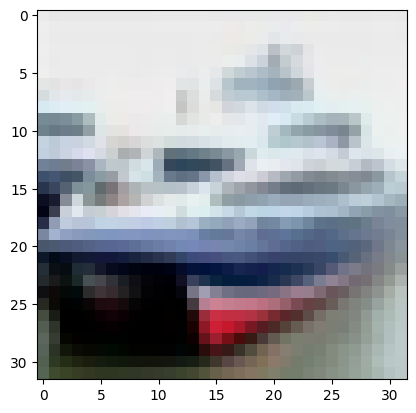

	ship


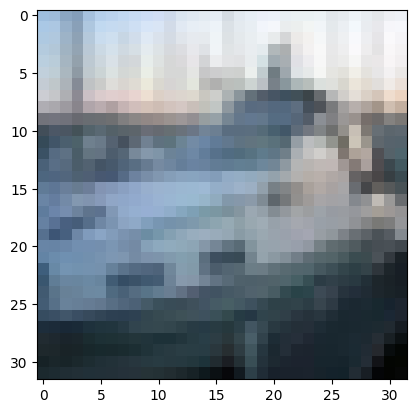

In [6]:
# Visualise data
import matplotlib.pyplot as plt
import numpy as np

train_batch, train_target = next(train_data.as_numpy_iterator())
test_batch, test_target = next(test_data.as_numpy_iterator())

print("Train batch:")
for i in range(3):
    print(f"\t{class_map[train_target[i][0]]}")
    plt.imshow(undo_normalisation(train_batch[i]))
    plt.show()

print("Test batch:")
for i in range(3):
    print(f"\t{class_map[test_target[i][0]]}")
    plt.imshow(undo_normalisation(test_batch[i]))
    plt.show()

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def mobilenet_v2_like(input_shape=(32, 32, 3), num_classes=10):
    def _inverted_res_block(i, filters, alpha, stride, expansion, block_id):
        prefix = 'block_{}_'.format(block_id)
        in_channels = i.shape[-1]
        x = i

        # Expand
        x = layers.Conv2D(expansion * in_channels, kernel_size=1, padding='valid',
                          use_bias=False, activation=None, name=prefix + 'expand')(x)
        x = layers.BatchNormalization(name=prefix + 'expand_BN')(x)
        x = layers.ReLU(name=prefix + 'expand_relu')(x)

        # Depthwise
        x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                                   use_bias=False, padding='same', name=prefix + 'depthwise')(x)
        x = layers.BatchNormalization(name=prefix + 'depthwise_BN')(x)
        x = layers.ReLU(name=prefix + 'depthwise_relu')(x)

        # Project
        pointwise_filters = int(filters * alpha)
        x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                          activation=None, name=prefix + 'project')(x)
        x = layers.BatchNormalization(name=prefix + 'project_BN')(x)

        if stride == 1:
            if in_channels != pointwise_filters:
                i = layers.Conv2D(pointwise_filters, kernel_size=1, padding='valid', use_bias=False,
                                  activation=None, name=prefix + 'adjust')(i)
            x = layers.Add(name=prefix + 'add')([i, x])
        return x

    i = layers.Input(shape=input_shape)
    x = i

    alpha = 1.0
    x = layers.Conv2D(32, kernel_size=3, strides=(1, 1),
                      padding='same', use_bias=False, name='Conv1')(x)
    x = layers.BatchNormalization(name='bn_Conv1')(x)
    x = layers.ReLU(name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)

    x = layers.Conv2D(1280, kernel_size=1, use_bias=False, name='Conv_1', padding="valid")(x)
    x = layers.BatchNormalization(name='Conv_1_bn')(x)
    x = layers.ReLU(name='out_relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, name='predictions')(x)

    return Model(i, x)


In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

tf.config.optimizer.set_jit(True)

train_data = train_data.prefetch(1)
test_data = test_data.prefetch(1)

model_mobilenet = mobilenet_v2_like()
model_mobilenet.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
              metrics=['accuracy'])

def train_model(model):
    def lr_schedule(epoch):
        if 0 <= epoch < 35:
            return 0.1
        if 35 <= epoch < 65:
            return 0.01
        return 0.001

    model.fit(
        train_data, validation_data=test_data,
        epochs=60, # Set no. of epochs
        callbacks=[
            LearningRateScheduler(lr_schedule),
            TensorBoard(log_dir="./tb_logs", profile_batch='25, 35')  # Profile between the 25th and 35th forward pass
        ])

#Load models and convert to TFLite

In [9]:
import pathlib
import os

In [10]:
# Helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  td = list(test_data.as_numpy_iterator())

  accuracy_list = []
  for i in td:
    prediction_digits = []
    #for test_image in x_test:
    for test_image in i[0]:
      # Pre-processing: add batch dimension and convert to float32 to match with
      # the model's input data format.
      test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
      interpreter.set_tensor(input_index, test_image)

      # Run inference.
      interpreter.invoke()

      # Post-processing: remove batch dimension and find the digit with highest
      # probability.
      output = interpreter.tensor(output_index)
      digit = np.argmax(output()[0])
      prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits).reshape(-1,1)
    accuracy = (prediction_digits == i[1]).mean()
    #print(accuracy)
    accuracy_list.append(accuracy)

  return np.mean(accuracy_list)

In [11]:
models_dir = pathlib.Path("./models/")
models_dir.mkdir(exist_ok=True, parents=True)

In [12]:
def convert_to_tflite(path):
  model = tf.keras.models.load_model(path)
  model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
                optimizer=SGD(learning_rate=0.1, momentum=0.9, weight_decay=0.0, nesterov=False),
                metrics=['accuracy'])
  model.evaluate(test_data)
  print(f"Total params: {model.count_params()}")

  # Convert model to a TensorFlow Lite model and save
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  model_tflite = converter.convert()

  models_dir = pathlib.Path("./models/")
  model_tflite_file = models_dir/"".join([path.split("/")[-1].split(".")[0], '.tflite'])
  model_tflite_file.write_bytes(model_tflite)
  return str(model_tflite_file)

In [13]:
path = convert_to_tflite('/content/model_mobilenet.h5')
print(path)

79/79 [==============================] - 18s 44ms/step - loss: 0.2422 - accuracy: 0.9289
Total params: 2330186
models/model_mobilenet.tflite


In [ ]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path=path)
interpreter.allocate_tensors()
print(f"{path} accuracy: {evaluate_model(interpreter)}")

In [4]:
!python tflite_tools/tflite_tools.py -i /content/model_mobilenet.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
| 118 | model/Conv1_relu/Relu;model/bn_Conv1/F...ock_5_project/Conv2D;model/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 119 |                           model/block_0_adjust/Conv2D1                           | (1, 32, 32, 16)  |          65,536 |
| 120 | model/block_0_expand_relu/Relu;model/b...ject/Conv2D;model/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 121 | model/block_0_depthwise_relu/Relu;mode...onv2D;model/bloc

###Knowledge distillation

In [15]:
path = convert_to_tflite('/content/model_student1.h5')
print(path)

79/79 [==============================] - 5s 25ms/step - loss: 0.3713 - accuracy: 0.8997
Total params: 1384394
models/model_student1.tflite


In [16]:
!python tflite_tools/tflite_tools.py -i /content/models/model_student1.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_2:0                             |  (1, 32, 32, 3)  |          12,288 |
|  88 | model_1/Conv1_relu/Relu;model_1/bn_Con...k_5_project/Conv2D;model_1/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
|  89 |                          model_1/block_0_adjust/Conv2D1                          | (1, 32, 32, 16)  |          65,536 |
|  90 | model_1/block_0_expand_relu/Relu;model...ct/Conv2D;model_1/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
|  91 | model_1/block_0_depthwise_relu/Relu;mo...v2D;model_1/bloc

In [17]:
path = convert_to_tflite('/content/model_student2.h5')
print(path)

79/79 [==============================] - 4s 19ms/step - loss: 0.3774 - accuracy: 0.8926
Total params: 1303322
models/model_student2.tflite


In [18]:
!python tflite_tools/tflite_tools.py -i /content/models/model_student2.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_3:0                             |  (1, 32, 32, 3)  |          12,288 |
|  70 | model_2/Conv1_relu/Relu;model_2/bn_Con...k_5_project/Conv2D;model_2/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
|  71 |                          model_2/block_0_adjust/Conv2D1                          | (1, 32, 32, 16)  |          65,536 |
|  72 | model_2/block_0_expand_relu/Relu;model...ct/Conv2D;model_2/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
|  73 | model_2/block_0_depthwise_relu/Relu;mo...v2D;model_2/bloc

In [19]:
path = convert_to_tflite('/content/model_student3.h5')
print(path)

79/79 [==============================] - 4s 12ms/step - loss: 0.4602 - accuracy: 0.8714
Total params: 635242
models/model_student3.tflite


In [20]:
!python tflite_tools/tflite_tools.py -i /content/models/model_student3.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+----+----------------------------------------------------------------------------------+------------------+-----------------+
| Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+----+----------------------------------------------------------------------------------+------------------+-----------------+
|  0 |                            serving_default_input_4:0                             |  (1, 32, 32, 3)  |          12,288 |
| 36 | model_3/Conv1_relu/Relu;model_3/bn_Con...k_3_project/Conv2D;model_3/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 37 |                          model_3/block_0_adjust/Conv2D1                          | (1, 32, 32, 16)  |          65,536 |
| 38 | model_3/block_0_expand_relu/Relu;model...ct/Conv2D;model_3/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 39 | model_3/block_0_depthwise_relu/Relu;mo...v2D;model_3/block_0_dept

In [21]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/models/model_student3.tflite')
interpreter.allocate_tensors()
print(f"{path} accuracy: {evaluate_model(interpreter)}")

models/model_student3.tflite accuracy: 0.8721321202531646


###Pruning

In [22]:
path = convert_to_tflite('/content/model_pruned60.h5')
print(path)

79/79 [==============================] - 7s 32ms/step - loss: 0.2920 - accuracy: 0.9114
Total params: 2330186
models/model_pruned60.tflite


In [23]:
!python tflite_tools/tflite_tools.py -i /content/models/model_pruned60.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
| 118 | model/Conv1_relu/Relu;model/bn_Conv1/F...ock_5_project/Conv2D;model/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 119 |                           model/block_0_adjust/Conv2D1                           | (1, 32, 32, 16)  |          65,536 |
| 120 | model/block_0_expand_relu/Relu;model/b...ject/Conv2D;model/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 121 | model/block_0_depthwise_relu/Relu;mode...onv2D;model/bloc

In [24]:
path = convert_to_tflite('/content/model_pruned70.h5')
print(path)

79/79 [==============================] - 6s 32ms/step - loss: 0.3015 - accuracy: 0.9060
Total params: 2330186
models/model_pruned70.tflite


In [25]:
!python tflite_tools/tflite_tools.py -i /content/models/model_pruned70.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
| 118 | model/Conv1_relu/Relu;model/bn_Conv1/F...ock_5_project/Conv2D;model/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 119 |                           model/block_0_adjust/Conv2D1                           | (1, 32, 32, 16)  |          65,536 |
| 120 | model/block_0_expand_relu/Relu;model/b...ject/Conv2D;model/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 121 | model/block_0_depthwise_relu/Relu;mode...onv2D;model/bloc

In [26]:
path = convert_to_tflite('/content/model_pruned80.h5')
print(path)

79/79 [==============================] - 6s 32ms/step - loss: 0.2953 - accuracy: 0.9046
Total params: 2330186
models/model_pruned80.tflite


In [27]:
!python tflite_tools/tflite_tools.py -i /content/models/model_pruned80.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
| 118 | model/Conv1_relu/Relu;model/bn_Conv1/F...ock_5_project/Conv2D;model/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 119 |                           model/block_0_adjust/Conv2D1                           | (1, 32, 32, 16)  |          65,536 |
| 120 | model/block_0_expand_relu/Relu;model/b...ject/Conv2D;model/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 121 | model/block_0_depthwise_relu/Relu;mode...onv2D;model/bloc

In [28]:
path = convert_to_tflite('/content/model_pruned90.h5')
print(path)

79/79 [==============================] - 6s 32ms/step - loss: 0.3622 - accuracy: 0.8807
Total params: 2330186
models/model_pruned90.tflite


In [29]:
!python tflite_tools/tflite_tools.py -i /content/models/model_pruned90.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
| 118 | model/Conv1_relu/Relu;model/bn_Conv1/F...ock_5_project/Conv2D;model/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 119 |                           model/block_0_adjust/Conv2D1                           | (1, 32, 32, 16)  |          65,536 |
| 120 | model/block_0_expand_relu/Relu;model/b...ject/Conv2D;model/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 121 | model/block_0_depthwise_relu/Relu;mode...onv2D;model/bloc

In [30]:
path = convert_to_tflite('/content/model_pruned95.h5')
print(path)

79/79 [==============================] - 6s 33ms/step - loss: 2.6027 - accuracy: 0.3197
Total params: 2330186
models/model_pruned95.tflite


In [35]:
!python tflite_tools/tflite_tools.py -i /content/models/model_pruned95.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
| 118 | model/Conv1_relu/Relu;model/bn_Conv1/F...ock_5_project/Conv2D;model/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 119 |                           model/block_0_adjust/Conv2D1                           | (1, 32, 32, 16)  |          65,536 |
| 120 | model/block_0_expand_relu/Relu;model/b...ject/Conv2D;model/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 121 | model/block_0_depthwise_relu/Relu;mode...onv2D;model/bloc

###Quantization

In [13]:
!python tflite_tools/tflite_tools.py -i /content/model_qat.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
|  60 | model/quantize_layer/AllValuesQuantize...akeQuantWithMinMaxVars/ReadVariableOp_1 |  (1, 32, 32, 3)  |           3,072 |
|  62 | model/quant_Conv1_relu/Relu;model/quan...project/Conv2D;model/quant_Conv1/Conv2D | (1, 32, 32, 32)  |          32,768 |
|  64 |                        model/quant_block_0_adjust/Conv2D                         | (1, 32, 32, 16)  |          16,384 |
|  66 | model/quant_block_0_expand_relu/Relu;m...onv2D;model/quan

In [49]:
!python tflite_tools/tflite_tools.py -i /content/models/model_quant_dr.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|  Id |                                      Tensor                                      |      Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |  (1, 32, 32, 3)  |          12,288 |
| 118 | model/Conv1_relu/Relu;model/bn_Conv1/F...ock_5_project/Conv2D;model/Conv1/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 119 |                           model/block_0_adjust/Conv2D1                           | (1, 32, 32, 16)  |          65,536 |
| 120 | model/block_0_expand_relu/Relu;model/b...ject/Conv2D;model/block_0_expand/Conv2D | (1, 32, 32, 32)  |         131,072 |
| 121 | model/block_0_depthwise_relu/Relu;mode...onv2D;model/bloc

In [48]:
!python tflite_tools/tflite_tools.py -i /content/models/model_quant_fp16.tflite --calc-macs --calc-size

Tensor information (weights excluded):
+-----+----------------------------------------------------------------------------------+-------------------+-----------------+
|  Id |                                      Tensor                                      |       Shape       | Size in RAM (B) |
+-----+----------------------------------------------------------------------------------+-------------------+-----------------+
|   0 |                            serving_default_input_1:0                             |   (1, 32, 32, 3)  |          12,288 |
| 118 |                         model/bn_Conv1/FusedBatchNormV31                         |       (32,)       |             128 |
| 119 |                    model/block_0_expand_BN/FusedBatchNormV31                     |       (32,)       |             128 |
| 120 |                   model/block_0_depthwise_BN/FusedBatchNormV31                   |       (32,)       |             128 |
| 121 |                    model/block_1_expand_BN/FusedBa

#Evaluate accuracy

In [29]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_mobilenet.tflite')
interpreter.allocate_tensors()
print(f"model_mobilenet accuracy: {evaluate_model(interpreter)}")

model_mobilenet accuracy: 0.928995253164557


In [30]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_pruned60.tflite')
interpreter.allocate_tensors()
print(f"model_pruned60 accuracy: {evaluate_model(interpreter)}")

model_pruned60 accuracy: 0.911689082278481


In [31]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_pruned70.tflite')
interpreter.allocate_tensors()
print(f"model_pruned70 accuracy: {evaluate_model(interpreter)}")

model_pruned70 accuracy: 0.9063488924050633


In [32]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_pruned80.tflite')
interpreter.allocate_tensors()
print(f"model_pruned80 accuracy: {evaluate_model(interpreter)}")

model_pruned80 accuracy: 0.9049643987341772


In [33]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_pruned90.tflite')
interpreter.allocate_tensors()
print(f"model_pruned90 accuracy: {evaluate_model(interpreter)}")

model_pruned90 accuracy: 0.8799446202531646


In [34]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_pruned95.tflite')
interpreter.allocate_tensors()
print(f"model_pruned95 accuracy: {evaluate_model(interpreter)}")

model_pruned95 accuracy: 0.32100474683544306


In [35]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_student1.tflite')
interpreter.allocate_tensors()
print(f"model_student1 accuracy: {evaluate_model(interpreter)}")

model_student1 accuracy: 0.900118670886076


In [36]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_student2.tflite')
interpreter.allocate_tensors()
print(f"model_student2 accuracy: {evaluate_model(interpreter)}")

model_student2 accuracy: 0.8924050632911392


In [37]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_student3.tflite')
interpreter.allocate_tensors()
print(f"model_student3 accuracy: {evaluate_model(interpreter)}")

model_student3 accuracy: 0.8721321202531646


In [38]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_qat.tflite')
interpreter.allocate_tensors()
print(f"/content/model_qat.tflite accuracy: {evaluate_model(interpreter)}")

/content/model_qat.tflite accuracy: 0.9139636075949367


In [39]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_quant_fp16.tflite')
interpreter.allocate_tensors()
print(f"/content/model_quant_fp16.tflite accuracy: {evaluate_model(interpreter)}")

/content/model_quant_fp16.tflite accuracy: 0.9288963607594937


In [40]:
# Evaluate accuracy
interpreter = tf.lite.Interpreter(model_path='/content/model_quant_dr.tflite')
interpreter.allocate_tensors()
print(f"/content/model_quant_dr.tflite accuracy: {evaluate_model(interpreter)}")

/content/model_quant_dr.tflite accuracy: 0.928995253164557
